# Localization 3

This is my implementation of the Localization part 3 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. The objective is to extend the code from Localization 1 and 2 and have it detect the bounding box of an image that can be scaled to different sizes.

Using a topless, pre-trained VGG16 network as a feature extractor we build a small dense layer with four outputs. The outputs represent the column, row, width and height of the Pokemon image.

As directed by the tutorial, I apply the sigmoid activation function to all four of the outputs.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-3.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-3.ipynb)

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

I started with the final code from [Localization 1]([https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-1.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-1.ipynb)) and then made the necessary modifications from there.

In [3]:
IMAGE_DIM = 200

The LocalizationSequence class I created to load and generate the Pokemon images used the PIL library to load the image from disk. For this code, I need to be able to create the image at different scales. Fortunately, the PIL library includes a method for doing this on the Image class.

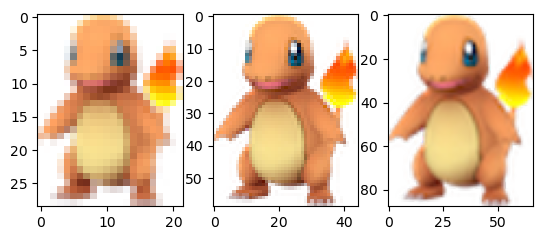

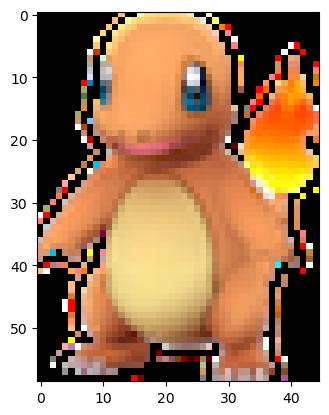

In [17]:
with Image.open('assets/images/charmander.png') as im:
    im_small = im.resize((int(im.width * 0.5), int(im.height * 0.5)))
    im_medium = im.copy()
    im_large = im.resize((int(im.width * 1.5), int(im.height * 1.5)))
    
ax = plt.subplot(1, 3, 1)
ax.imshow(im_small)

ax = plt.subplot(1, 3, 2)
ax.imshow(im_medium)

ax = plt.subplot(1, 3, 3)
ax.imshow(im_large)

plt.show()

plt.imshow(np.array(im_medium)[:, :, 0:3])

In [28]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        with Image.open('assets/images/charmander.png') as im:
            self.charmander = im.copy()
        
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1 and applies the sigmoid function
        so it matches the output of the model.
        """
        return tf.math.sigmoid(y / IMAGE_DIM)
        
        
    def generate_charmander(self):
        """
        Generates a Charmander pokemon of a random size from 0.5 to
        1.5 the scale of the original one.
        """
        scale = random.uniform(0.5, 1.5)
        poke = self.charmander.resize(
            (int(self.charmander.width * scale), int(self.charmander.height * scale))
        )
        
        return poke
        
        
    def generate_image(self):
        """
        Generates a random image with a Charmander inside it. 
        """
        img = np.zeros((IMAGE_DIM, IMAGE_DIM, 3))
        
        poke = self.generate_charmander()
        (char_width, char_height) = poke.size
        
        # create a numpy array from the image and strip out the
        # alpha channel
        poke_arr = np.array(poke)[:, :, 0:3]
        
        # normalize colours
        poke_arr = poke_arr / 255.
        
        char_top = random.randint(1, IMAGE_DIM - char_height)
        char_left = random.randint(1, IMAGE_DIM - char_width)
        
        img[char_top:char_top + char_height, 
            char_left:char_left + char_width] = poke_arr
        
        return img, self.preprocess_y_value(
            np.array([char_top, char_left, char_height, char_width])
        )
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return the batch size.
        """
        return self.batch_size
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        batch_y = np.empty([self.batch_size, 4], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
    


Test out the LocalizationSequence by creating a batch of images. It doesn't matter what value is passed as the index parameter of `LocalizationSequence.__getitem__(idx)` as it'll generate a random batch every time.

In [29]:
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

Now we can draw them out and see what we generated.

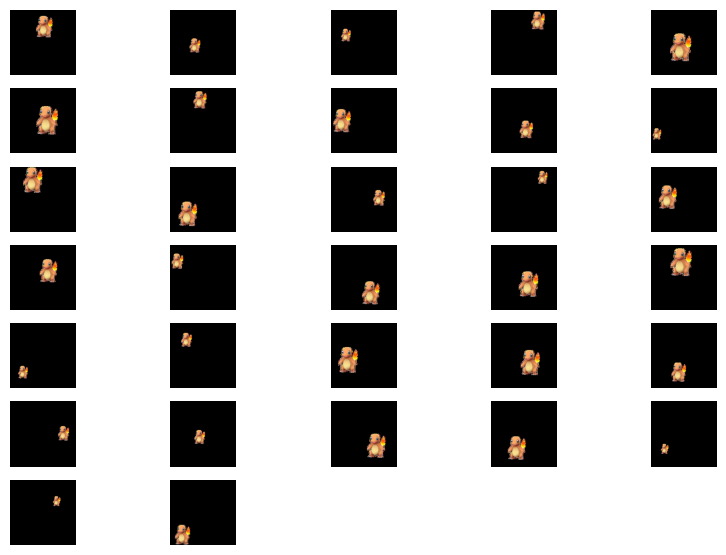

In [30]:
plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.__len__())):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()

In [61]:
class LearningRateReducer(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    if epoch == 4:
        new_lr = 0.0001 
        print(f"\nEpoch: {epoch}. Reducing Learning Rate from {old_lr} to {new_lr}")
        self.model.optimizer.lr.assign(new_lr)

    if epoch == 7:
        new_lr = 0.00001 
        print(f"\nEpoch: {epoch}. Reducing Learning Rate from {old_lr} to {new_lr}")
        self.model.optimizer.lr.assign(new_lr)
        


To recap, I created the model by starting with a trained, topless VGG16, flattening the outputs as they'll be 2D tensors, and the final dense layer with four outputs and sigmoid activation.

We want to make sure we don't try and train the Conv2D layers as it'll take too long so that part of the model is marked as untrainable.

It's then compiled with binary crossentropy as the loss function and the Adam optimizer.

In [62]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(4, activation="sigmoid")(x)

# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "Localization_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)

You can see from the summary above that nearly all of the weights are untrainable but the final flatten and dense layer weights are.

Next we train the model using the LocalizationSequence object.

In [63]:
history = model.fit(seq, epochs=10, callbacks=[LearningRateReducer()])

Epoch 1/10
32/32 [==============================] - 143s 4s/step - loss: 0.7246 - accuracy: 0.4092
Epoch 2/10
32/32 [==============================] - 158s 5s/step - loss: 0.6804 - accuracy: 0.6992
Epoch 3/10
32/32 [==============================] - 165s 5s/step - loss: 0.6784 - accuracy: 0.8252
Epoch 4/10
32/32 [==============================] - 166s 5s/step - loss: 0.6782 - accuracy: 0.8242
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.8691
Epoch: 4. Reducing Learning Rate from 0.0010000000474974513 to 0.0001
32/32 [==============================] - 168s 5s/step - loss: 0.6776 - accuracy: 0.8691
Epoch 6/10
32/32 [==============================] - 167s 5s/step - loss: 0.6777 - accuracy: 0.8828
Epoch 7/10
32/32 [==============================] - 167s 5s/step - loss: 0.6774 - accuracy: 0.8760
Epoch 8/10
32/32 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.9023
Epoch: 7. Reducing Learning Rate from 9.999999747378752e-05 

Plot the accuracy from the `model.fit()`.

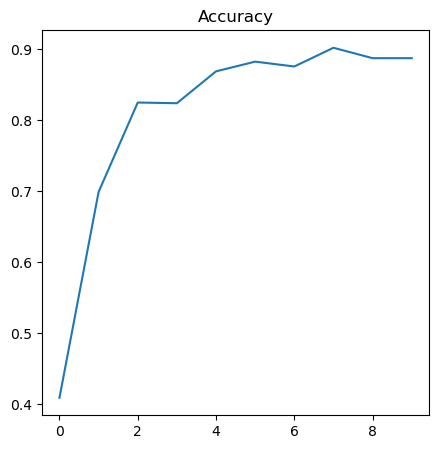

In [64]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [65]:
model.save('saved-models/localization-3.h5', overwrite=True)

The `reverse_sigmoid()` function reverses the sigmoid activation to a value proportional to the image size using the equation:

$$\hat{y} = \ln \left[ {y\over{(1 - y)}} \right]$$

In [66]:
def reverse_sigmoid(y):
    return np.log(y / (1 - y))

The `to_pil_rect()` function takes the y outputs from the model, reverses the sigmoid activation and converts the values into the correct coordinates for the input.

In [67]:
def to_pil_rect(y):
    rv = reverse_sigmoid(y)
    rv = rv * IMAGE_DIM
    rv = np.clip(rv, 1, IMAGE_DIM - 1)
    [top, left, height, width] = rv
    height += top
    width += left
    rv[2] = height
    rv[3] = width
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [68]:
x, y = seq.__getitem__(0)
print(f'Generated data for predictions: {x.shape}')

Generated data for predictions: (32, 200, 200, 3)


Use the trained model to make some predictions from the new batch.

In [69]:
y_predicted = model.predict(x)

1/1 [==============================] - 5s 5s/step


Create the boxes for both the actual boxes and the predicted ones.

In [70]:
predicted_boxes = np.zeros((seq.batch_size, 4))
actual_boxes = np.zeros((seq.batch_size, 4))

for i, pred in enumerate(y_predicted):
    predicted_boxes[i] = to_pil_rect(pred)
    actual_boxes[i] = to_pil_rect(y[i])

Convert the numpy array into a PIL image so we can work with it as an image.

In [71]:
def add_bounding_boxes():
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)

        draw.rectangle(
            [actual_boxes[i][1], 
             actual_boxes[i][0], 
             actual_boxes[i][3], 
             actual_boxes[i][2]], outline='yellow')

        draw.rectangle(
            [predicted_boxes[i][1], 
             predicted_boxes[i][0], 
             predicted_boxes[i][3], 
             predicted_boxes[i][2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [72]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them as we did previously in Object Localization 1. 

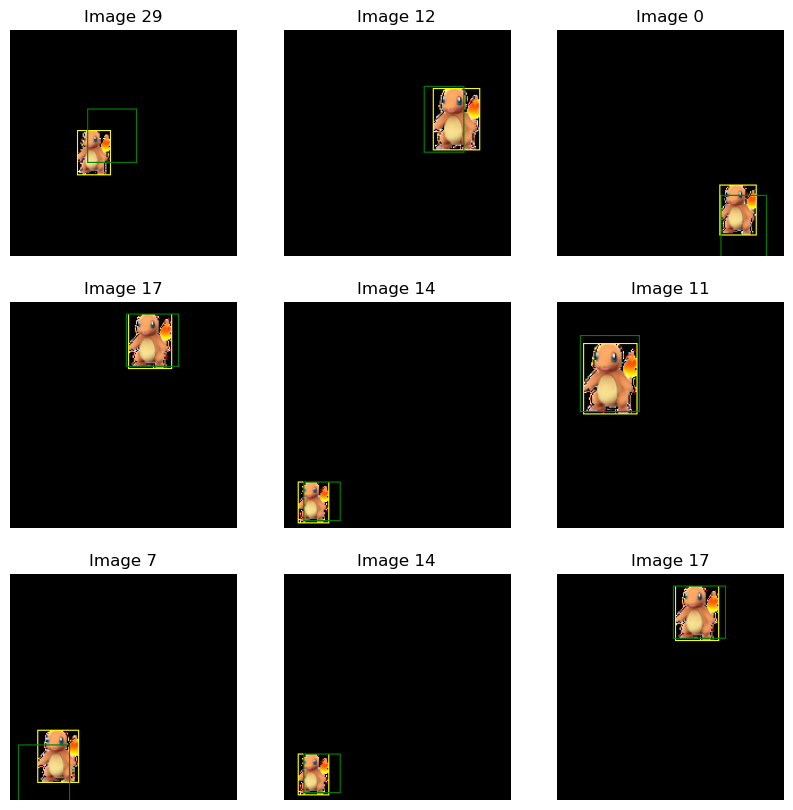

In [73]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'Image {im_idx}')

In the output above you can see the green boxes that are the results of the predictions and the yellow boxes that use the same maths to reverse the sigmoid function and validate that that maths is correct.